In [ ]:
# 🧪 Imports and data prep
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

torch.manual_seed(43)
np.random.seed(43)

depth = 20

# Generate the dataset
X, y = make_circles(n_samples=2000, noise=0.05, factor=0.2)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

print(X_train.shape)


torch.Size([2100, 2])


In [ ]:
class FFnet(nn.Module):
    def __init__(self, depth=depth, width=2, bottleneck=False, activation='tanh'):
        super().__init__()
        act_fn = nn.Tanh if activation == 'tanh' else nn.ReLU
        self.activations = []
        layers = []
        in_features = 2

        for i in range(depth):
            out_features = 1 if bottleneck and i == depth - 2 else width
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.BatchNorm1d(out_features))
            layers.append(act_fn())
            in_features = out_features

        layers.append(nn.Linear(in_features, 1))  # output layer
        self.net = nn.Sequential(*layers)

    def forward(self, x, collect_activations=False):
        # Add a batch dimension if input is 1D
        if x.dim() == 1:
            x = x.unsqueeze(0)  # Shape becomes [1, features]
        self.activations = []
        for layer in self.net[:-1]:
            x = layer(x)
            if collect_activations and isinstance(layer, (nn.Tanh, nn.ReLU)):
                self.activations.append(x.detach().cpu().numpy())
        x = self.net[-1](x)
        return torch.sigmoid(x)


In [25]:
def compute_accuracy(y_pred, y_true):
    """
    y_pred: float32 predictions (sigmoid outputs)
    y_true: float32 ground truth labels (0 or 1)
    """
    y_pred_binary = (y_pred >= 0.5).int()
    y_true_binary = y_true.int()
    correct = (y_pred_binary == y_true_binary).sum().item()
    total = y_true.shape[0]
    return correct / total

def train_model(model, X_train, y_train, X_test, y_test, 
                                epochs=300, lr=0.01, patience=300, batch_size=128):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    best_acc = 0
    patience_counter = 0
    losses = []

    # Create DataLoader for training data
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        losses.append(epoch_loss / len(train_loader))

        # Evaluate on test data
        model.eval()
        with torch.no_grad():
            test_preds = model(X_test)
            acc = compute_accuracy(test_preds, y_test)
        model.train()

        if acc > best_acc:
            best_acc = acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⏹️ Early stopping at epoch {epoch}, best acc: {best_acc:.3f}")
                break

    return best_acc, losses



def train_until_threshold(model_class, X_train, y_train, X_test, y_test,
                          max_retries=10, threshold=0.95, **model_kwargs):
    for attempt in range(1, max_retries + 1):
        model = model_class(**model_kwargs)
        acc, losses = train_model(model, X_train, y_train, X_test, y_test)
        print(f"[Attempt {attempt}] Accuracy: {acc:.3f}")
        if acc >= threshold:
            print(f"✅ Success after {attempt} attempt(s)!")
            return model, acc, losses
    print("❌ Failed to reach threshold.")
    return model, acc, losses



In [26]:
def plot_loss_curve(losses, title="Training Loss"):
    plt.figure(figsize=(6, 4))
    plt.plot(losses, label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross Entropy Loss")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    model.eval()
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)
    with torch.no_grad():
        preds = model(grid_tensor).numpy().reshape(xx.shape)
    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, preds, levels=50, cmap='coolwarm', alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), cmap='bwr', edgecolors='k')
    plt.title(title)
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.grid(True)
    plt.show()


## plot SVs

In [33]:


def plot_singular_values(model, title=''):
    """
    For each Linear layer in the model, compute the singular values using torch.svd,
    and plot them by layer index (x-axis) vs. singular value (y-axis).
    This version ensures all singular values are visible and x-ticks align with integer layer indices.
    """
    linear_layers = [module for module in model.modules() if isinstance(module, nn.Linear)]

    all_singular_values = []
    max_sv = float('-inf')
    min_sv = float('inf')

    for i, layer in enumerate(linear_layers):
        W = layer.weight.detach().cpu()
        try:
            _, S, _ = torch.svd(W)
            sv_numpy = S.numpy()
            all_singular_values.append((i, sv_numpy))
            max_sv = max(max_sv, sv_numpy.max())
            min_sv = min(min_sv, sv_numpy.min())
        except RuntimeError:
            print(f"⚠️ torch.svd failed on Layer {i+1} — possibly due to singularity.")
            all_singular_values.append((i, []))

    # Plot each singular value as a separate point per layer
    plt.figure()
    for layer_idx, svals in all_singular_values:
        for sv in svals:
            plt.scatter(layer_idx, sv, color='blue', alpha=0.4)

    plt.title("SVs" + title)
    plt.xlabel("Layer Index")
    plt.ylabel("Singular Value (log scale)")
    plt.yscale("log")

    # Ensure y-axis covers all singular values
    y_max = max_sv * 1.2
    plt.ylim([1e-4, y_max])

    # Use integer x-ticks only for layer indices
    layer_indices = list(range(len(linear_layers)))
    plt.xticks(layer_indices)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()




In [34]:
# Train both models
model_base, acc_base, losses_base = train_until_threshold(
    FFnet, X_train, y_train, X_test, y_test,
    max_retries=20, threshold=0.99,
    depth=15, width=2, bottleneck=False, activation='tanh'
)

model_bottleneck, acc_bottleneck, losses_bottleneck = train_until_threshold(
    FFnet, X_train, y_train, X_test, y_test,
    max_retries=10, threshold=0.99,
    depth=15, width=2, bottleneck=True, activation='tanh'
)

# Plot decision boundaries
plot_decision_boundary(model_base, X_test.numpy(), y_test.numpy(), title="Baseline Model")
plot_decision_boundary(model_bottleneck, X_test.numpy(), y_test.numpy(), title="Bottleneck Model")


KeyboardInterrupt: 

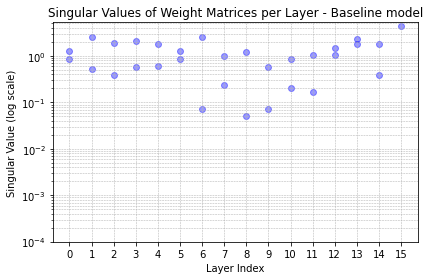

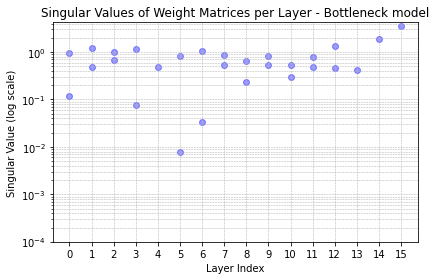

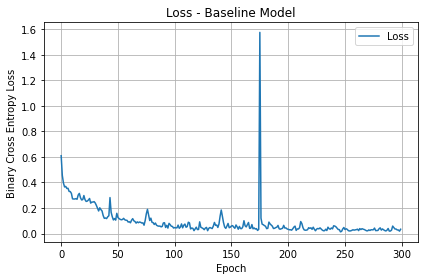

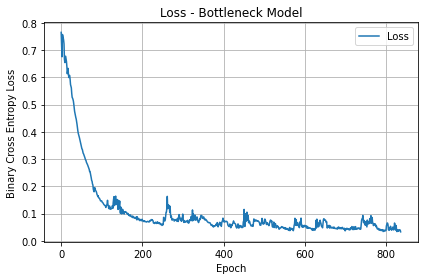

In [29]:

# Plot activation heatmaps
plot_singular_values(model_base, title = 'Baseline model')
plot_singular_values(model_bottleneck, title = 'Bottleneck model')

# Plot loss curves
plot_loss_curve(losses_base, "Loss - Baseline Model")
plot_loss_curve(losses_bottleneck, "Loss - Bottleneck Model")


## Train wide model

In [30]:
def train_model_new(
    model, X_train, y_train, X_test, y_test,
    epochs=1000, lr=0.01, patience=300,
    plot_interval=100
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    best_acc = 0
    patience_counter = 0
    losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            test_preds = model(X_test)
            acc = compute_accuracy(test_preds, y_test)

        if acc > best_acc:
            best_acc = acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⏹️ Early stopping at epoch {epoch}, best acc: {best_acc:.3f}")
                break

        # Plot every 'plot_interval' epochs
        if epoch % plot_interval == 0 or epoch == epochs:
            print(f"📊 Epoch {epoch} — Accuracy: {acc:.3f}")
            plot_decision_boundary(model, X_train.numpy(), y_train.numpy(), title=f"Decision Boundary @ Epoch {epoch}")
            plot_singular_values(model, title=f"Epoch {epoch}")

    return best_acc, losses

In [31]:
def plot_weight_heatmaps(model, title=''):
    import matplotlib.pyplot as plt
    import numpy as np
    linear_layers = [module for module in model.modules() if isinstance(module, nn.Linear)]

    n_layers = len(linear_layers)
    if n_layers == 0:
        print("No Linear layers with parameters found.")
        return

    fig, axes = plt.subplots(1, n_layers, figsize=(3 * n_layers, 3), squeeze=False)
    axes = axes[0]

    for i, layer in enumerate(linear_layers):
        weight = layer.weight.detach().cpu().numpy()
        weight = abs(weight)
        ax = axes[i]
        im = ax.imshow(weight, cmap='viridis', vmin = 0, vmax = 5, aspect='equal')

        ax.set_title(f"Layer {i}")
        ax.set_xlabel("Out")
        ax.set_ylabel("In")
       

        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.suptitle("Weight Matrices Heatmaps - " + title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


📊 Epoch 50 — Accuracy: 0.868


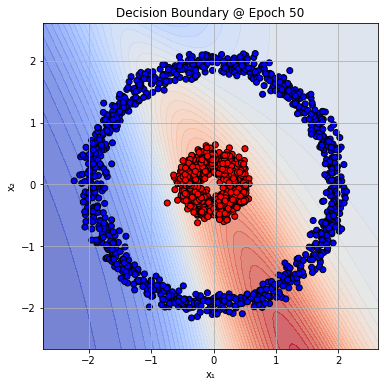

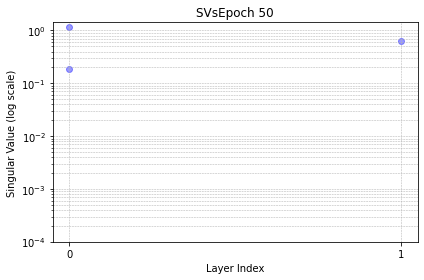

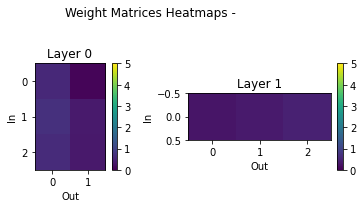

📊 Epoch 50 — Accuracy: 0.881


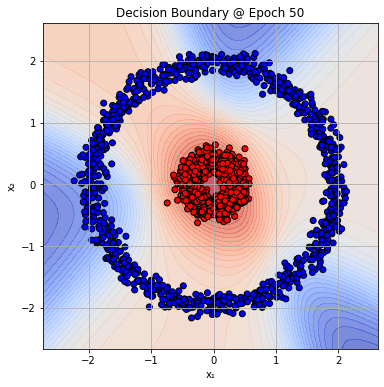

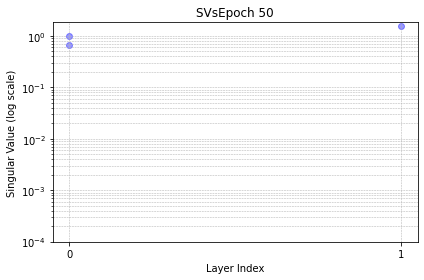

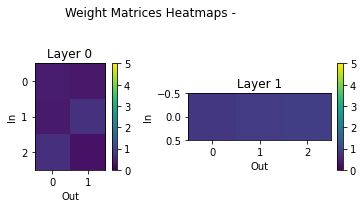

📊 Epoch 50 — Accuracy: 0.951


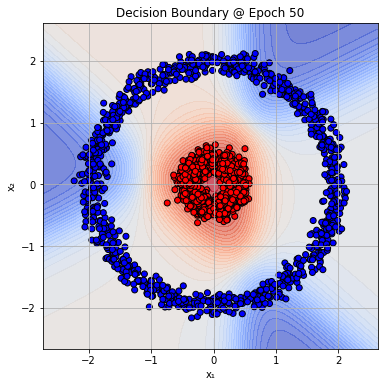

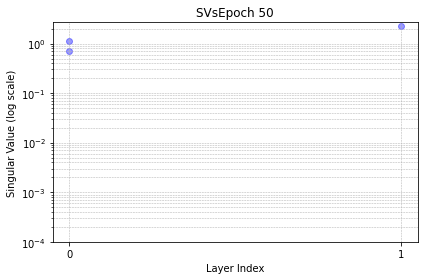

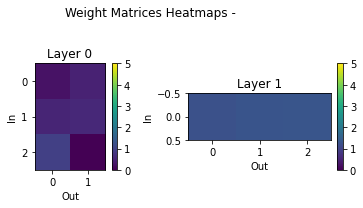

📊 Epoch 50 — Accuracy: 1.000


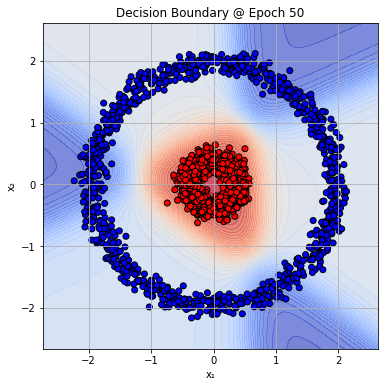

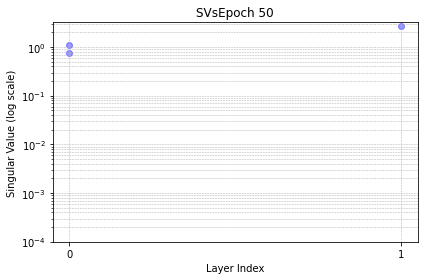

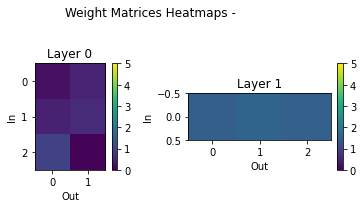

📊 Epoch 50 — Accuracy: 1.000


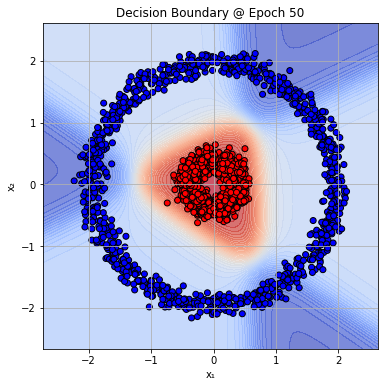

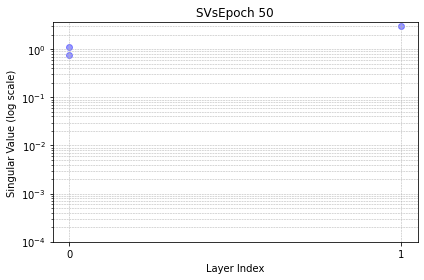

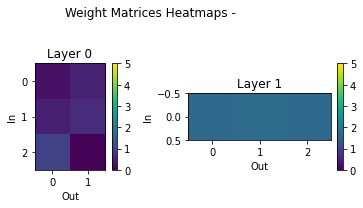

📊 Epoch 50 — Accuracy: 1.000


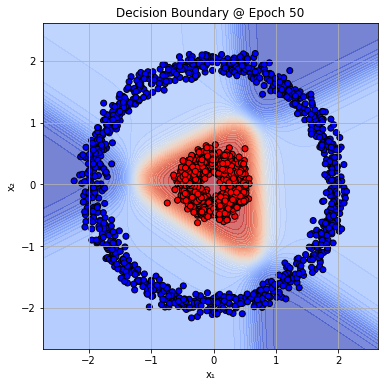

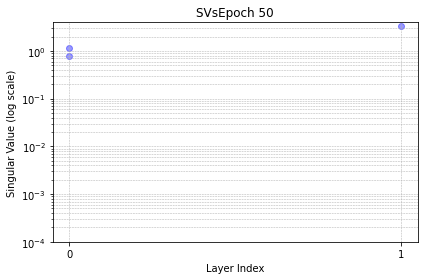

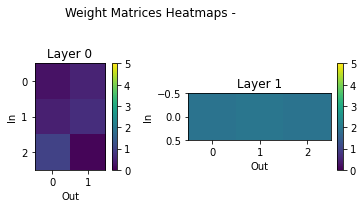

📊 Epoch 50 — Accuracy: 1.000


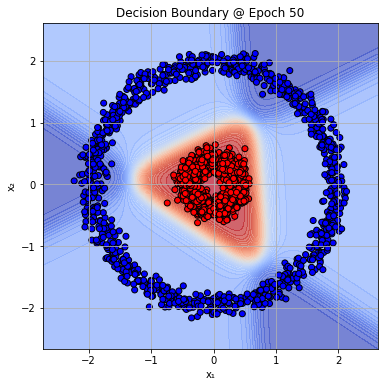

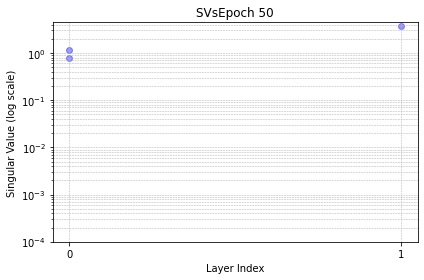

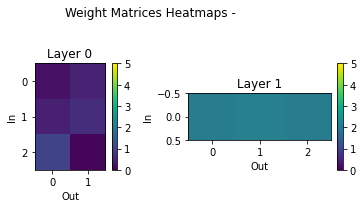

📊 Epoch 50 — Accuracy: 1.000


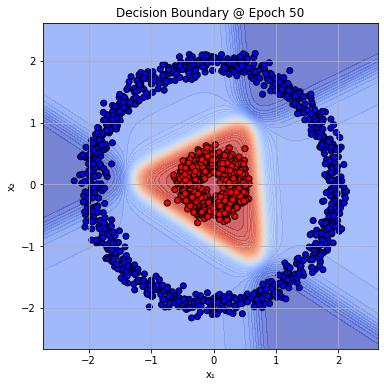

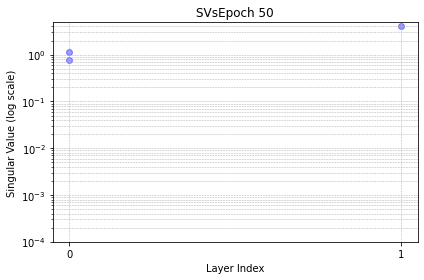

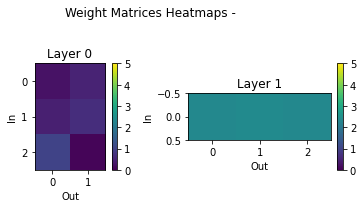

📊 Epoch 50 — Accuracy: 0.999


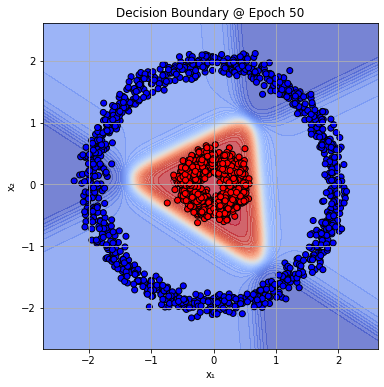

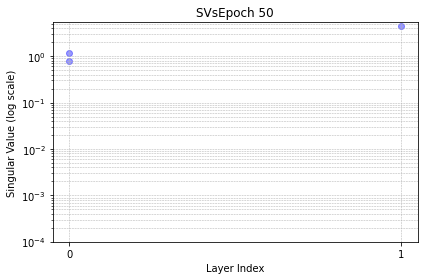

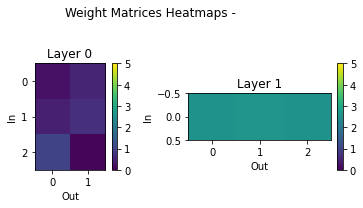

📊 Epoch 50 — Accuracy: 0.999


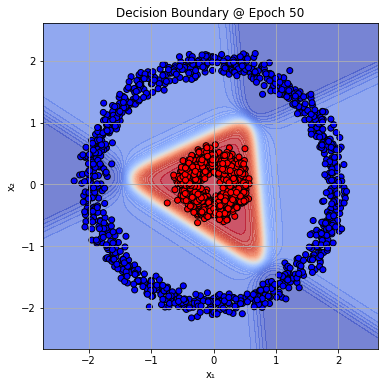

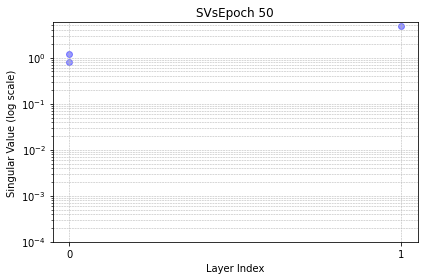

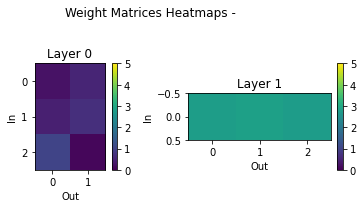

In [35]:
model_wide = FFnet(depth=1, width=3, bottleneck=False, activation='tanh')
for plot in range(10):
    acc, losses = train_model_new(model_wide, X_train, y_train, X_test, y_test, epochs=50, plot_interval=50)
    plot_weight_heatmaps(model_wide)


In [37]:
# Define a grid over the input space.
grid_size = 200 # Adjust as needed.

def psi_manual(x, func):
    """
    x: a tensor of shape (2,) representing a point in R^2.
    model: a function mapping R^2 to R^2.
    
    Returns:
      The smallest singular value of the Jacobian of model at x.
    """
    # Ensure x is a leaf variable with gradient tracking enabled.
    x = x.clone().detach().requires_grad_(True)
    
    # Define a lambda function to ensure accurate input-output mapping
    # func = lambda inp: model(inp, output_layer = False)
    
    # Compute the Jacobian using torch.autograd.functional.jacobian (compatible with Python 3.8)
    jacobian = torch.autograd.functional.jacobian(func, x, create_graph=True)
    
    # Compute singular values using svdvals (available in PyTorch 1.8, compatible with Python 3.8)
    singular_values = torch.svd(jacobian, compute_uv=False)[1]
    
   
    return singular_values.detach().numpy()



x_range = np.linspace(-1, 1, grid_size)
y_range = np.linspace(-1, 1, grid_size)
psi_values = np.zeros((grid_size, grid_size, 2))

# Put the model in evaluation mode.
model_wide.eval()
func = lambda inp: model_wide(inp)

model_wide(torch.tensor([1.,2.]))

# # Evaluate psi(x) over the grid.
# for i, xv in enumerate(x_range):
#     for j, yv in enumerate(y_range):
#         # Create a 2D point as a torch tensor.
#         x_point = torch.tensor([xv, yv], dtype=torch.float32)
#         psi_values[j, i,:] = psi_manual(x_point, func) #one subtlety here: if there is only one SV it gets broadcast to all dimensions of psi_values[j,i,:] in the last dimension. this reduces if statements for e.g. the last layer, but we need to notice that the SINGLE SV gets plotted twice 

ValueError: expected 2D or 3D input (got 1D input)